In [1]:
import pandas as pd

# Load the ratings dataset
ratings_df = pd.read_csv('ml-latest-small/ratings.csv')

# Filter ratings above 2
filtered_ratings_df = ratings_df[ratings_df['rating'] > 2]

# Group by 'userId' and count the number of movies rated by each user
user_movie_counts = filtered_ratings_df.groupby('userId')['movieId'].count().reset_index()
user_movie_counts.columns = ['userId', 'num_movies_rated']

# Filter users who have rated more than 10 movies
active_users = user_movie_counts[user_movie_counts['num_movies_rated'] > 10]

# Filter the transactional data based on active users
transactional_data = filtered_ratings_df[filtered_ratings_df['userId'].isin(active_users['userId'])]

# Group by 'userId' and aggregate movies
transactional_data = transactional_data.groupby('userId')['movieId'].apply(list).reset_index()
transactional_data.columns = ['userId', 'movies_rated_above_2']

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Split data into training and test sets
train_data = []
test_data = []

for _, row in transactional_data.iterrows():
    user_id = row['userId']
    movies_rated_above_2 = row['movies_rated_above_2']
    
    train_movies, test_movies = train_test_split(movies_rated_above_2, test_size=0.2, random_state=42)
    
    train_data.append({'userId': user_id, 'movies_rated_above_2': train_movies})
    test_data.append({'userId': user_id, 'test_movies': test_movies})

# Create DataFrames for training and test data after the loop
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

In [3]:
minsup = 9

In [4]:
# Create an empty dictionary to store movie support
movie_support = {}

# Iterate through each user's movies in the training set
for _, row in train_df.iterrows():
    train_movies = row['movies_rated_above_2']
    
    # Count the occurrences of each movie and update support
    for movie in train_movies:
        if movie in movie_support:
            movie_support[movie] += 1
        else:
            movie_support[movie] = 1

# Convert the movie support dictionary to a DataFrame
support_df = pd.DataFrame(list(movie_support.items()), columns=['movieId', 'support'])

# Sort the DataFrame by support in descending order
support_df = support_df.sort_values(by='support', ascending=False)

In [5]:
# Filter the DataFrame to keep only movies with support >= minsup
trimmed_support_df = support_df[support_df['support'] >= minsup]

In [6]:

# Filter movies in train_df based on minsup
train_df['movies_rated_above_2'] = train_df['movies_rated_above_2'].apply(
    lambda movies: [movie for movie in movies if movie in trimmed_support_df['movieId'].values]
)

# Function to get the support count of a movie
def get_support_count(movie):
    return trimmed_support_df[trimmed_support_df['movieId'] == movie]['support'].values[0]

# Sort movies by support count in descending order
train_df['movies_rated_above_2'] = train_df['movies_rated_above_2'].apply(
    lambda movies: sorted(movies, key=get_support_count, reverse=True)
)


In [7]:
# Define a function to get the support count of a movie from the trimmed_support_df
def get_support(movie_id):
    support_row = trimmed_support_df[trimmed_support_df['movieId'] == movie_id]
    if not support_row.empty:
        return support_row['support'].values[0]
    else:
        return 0  # Default support count for movies not found in trimmed_support_df

# Sort the movies_rated_above_2 column in train_df based on trimmed_support count
train_df['movies_rated_above_2'] = train_df['movies_rated_above_2'].apply(
    lambda movies: sorted(movies, key=get_support, reverse=True)
)

# Trie Data Structure Documentation

The code below implements a Trie data structure. A Trie, also known as a Prefix Tree, is a tree-like data structure used to efficiently store and retrieve a dynamic set of strings. Each node in the Trie represents a character, and the path from the root to a particular node forms a string.

## `TrieNode` Class

### Constructor `__init__(self)`

- Initializes a `TrieNode` object.
- Attributes:
  - `char`: The character associated with the node. Default value is -1.
  - `count`: The count of words that pass through this node. Default value is 0.
  - `children`: A list of child nodes, each representing a character. Initially empty.


In [8]:
class TrieNode:
    def __init__(self):
        self.char = -1
        self.count = 0
        self.children = []

root = TrieNode()

## `root` Variable

- Initializes the root of the Trie as an instance of the `TrieNode` class. This root serves as the starting point for inserting and searching words in the Trie.

## `insert(word)` Function

### Parameters:
- `word` (str): The word to be inserted into the Trie.

### Operation:
- Inserts a word into the Trie by iterating through each character in the word and creating the necessary nodes as needed.
- If a character already exists as a child of the current node, it increments the count for that character's node.
- If a character does not exist as a child of the current node, it creates a new node and appends it to the list of children, updating the count.
- The `root` variable always remains the starting point for each insertion.


In [9]:
def insert(word):
    node = root
    for char in word:
        found = False
        for child in node.children:
            if child.char == char:
                node = child
                node.count += 1
                found = True
                break

        if not found:
            new_node = TrieNode()
            new_node.char = char
            new_node.count = 1
            node.children.append(new_node)
            node = new_node

In [10]:
for _, row in train_df.iterrows():
    transaction = row['movies_rated_above_2']
    insert(transaction)

# DFS Function for Trie Pattern Matching Documentation

The code below defines a Depth-First Search (DFS) function used for pattern matching in a Trie data structure. This function traverses the Trie and generates conditional pattern bases for a specific item.

## Function: `dfs(node, pattern, item, patBase)`

### Parameters:
- `node` (TrieNode): The current node being explored in the Trie.
- `pattern` (list): A list of characters representing the current pattern being constructed.
- `item` (int): The item (character) for which conditional pattern bases are generated.
- `patBase` (dict): A dictionary that stores the conditional pattern bases.

### Operation:
- The `dfs` function recursively explores the Trie to construct conditional pattern bases for a specific item.
- When the current node's character matches the specified item, the function creates a conditional pattern base for the pattern constructed so far.
- The conditional pattern base is stored in the `patBase` dictionary with the pattern as a tuple key and the count as the value.


In [11]:
condPatBase = {}
def dfs(node, pattern, item, patBase):
    if node.char == item:
        patBase[tuple(pattern.copy())] = node.count
        return

    for child in node.children:
        new_pattern = pattern.copy()
        if node.char != -1:
            new_pattern.append(node.char)
        dfs(child, new_pattern, item, patBase)

In [12]:
for _, trimmed_row in trimmed_support_df.iterrows():
    pattern = []
    patBase = {}
    movie_id = trimmed_row['movieId']  
    dfs(root, pattern, int(movie_id), patBase)
    condPatBase[int(movie_id)] = patBase.copy()


# Conditional FP-Tree Construction Documentation

The code below constructs conditional FP-trees based on conditional pattern bases derived from a Trie data structure. FP-trees are a data structure used for frequent pattern mining, and the code builds these trees for each conditional pattern base.

## Conditional FP-Tree Construction Loop

### Variables:
- `conditional_fp_trees` (list): A list used to store conditional FP-trees.

### Operation:
- The code iterates through each item in the `condPatBase` dictionary, where each item represents a movie and its corresponding conditional pattern base.
- For each conditional pattern in the pattern base, it calculates the total count by summing up the support values (counts).
- It then identifies the intersection of patterns by comparing the patterns and stores the result in the `intersection_list` variable.
- If the intersection list is not empty, it constructs a conditional FP-tree entry for the movie with the intersection pattern and its total count.
- The conditional FP-tree entry is added to the `conditional_fp_trees` list.


In [13]:
conditional_fp_trees = []

for movie_id, patterns in condPatBase.items():
    count = 0
    intersection_list = []
    for idx, (pattern, support) in enumerate(patterns.items()):
        count += support
        if idx == 0:
            intersection_list = list(pattern)
        else:
            list2 = intersection_list.copy()
            intersection_list = [item for item in pattern if item in list2]
    if len(intersection_list) != 0:
        conditional_fp_trees.append(
            {movie_id : {
                tuple(intersection_list) : count
            }}
        )

### Parameters:
- `s` (iterable): The input set from which subsets are generated.
- `n` (int): The size of subsets to be generated.

### Operation:
- The `findsubsets` function uses itertools to generate all combinations of `n` elements from the input set `s`.
- It returns the list of subsets as a list of tuples.

## Frequent Pattern Itemsets Generation Loop

### Variables:
- `frequent_pattern_itemsets` (list): A list used to store the generated frequent pattern itemsets.

### Operation:
- The code iterates through each conditional FP-tree in the `conditional_fp_trees` list.
- For each conditional FP-tree, it extracts movie IDs and their associated patterns.
- It then generates all possible subsets of these patterns for different lengths (from 1 to the length of the pattern).
- Each subset is combined with the movie ID and its count to form a frequent pattern itemset.
- These itemsets are added to the `frequent_pattern_itemsets` list.


In [14]:
import itertools
def findsubsets(s, n):
    return list(itertools.combinations(s, n))
 
frequent_pattern_itemsets = []

for cond_fp_tree in conditional_fp_trees:
    for movie_id, patterns in cond_fp_tree.items():
        for pattern, count in patterns.items():
            # print(pattern, count)
            subset = []
            l = len(pattern)
            for n in range(1, l+1):
                subset.extend(list(findsubsets(pattern, n)))
            # print(movie_id)
            subset = [{tuple(list(item) + [movie_id]): count} for item in subset]
            frequent_pattern_itemsets.extend(
        tuple(subset)
                
            )

### Variables:
- `association_rules` (list): A list used to store the generated association rules.

### Operation:
- The code iterates through each frequent itemset in the `frequent_pattern_itemsets` list.
- For each itemset, it extracts the individual items and their counts.
- It calculates the confidence for each itemset by dividing the count by the support (frequency) of the item in a given dataset.
- An association rule is constructed with the following components:
  - "X": The item being analyzed (antecedent).
  - "Y": The remaining items in the itemset (consequent).
  - "support": The support (count) of the itemset.
  - "confidence": The confidence of the rule.
- Each association rule is added to the `association_rules` list.

## Sorting Association Rules

### Operation:
- The code performs two sorting operations on the generated association rules:
  - Sorts the association rules by support in descending order to find the top 100 rules based on support.
  - Sorts the association rules by confidence in descending order to find the top 100 rules based on confidence.


In [15]:
association_rules = []

for freq_itemset in frequent_pattern_itemsets:
    for itemset, count in freq_itemset.items():
        for item in itemset:
            rule = {
                "X": item,
                "Y": list(set(itemset).difference([item])),
                "support": count,
                "confidence": count / support_df[support_df['movieId'] == item]['support'].values[0]
            }
            association_rules.append(rule)

In [16]:
# Sort by support in descending order
association_rules_sorted_by_support = sorted(association_rules, key=lambda x: x['support'], reverse=True)

association_rules_sorted_by_support_top100 = association_rules_sorted_by_support[:100]

In [17]:
# Sort by confidence in descending order
association_rules_sorted_by_confidence = sorted(association_rules, key=lambda x: x['confidence'], reverse=True)

association_rules_sorted_by_confidence_top100 = association_rules_sorted_by_confidence[:100]

In [18]:
movies_df = pd.read_csv('ml-latest-small/movies.csv')
movies_df = movies_df[['movieId', 'title']]

In [19]:
association_rules_sorted_by_support_top100_titles = [{item['X']: item['Y']} for item in association_rules_sorted_by_support_top100]
association_rules_sorted_by_support_top100_titles = [{movies_df[movies_df['movieId'] == list(item.keys())[0]]['title'].values[0]: [movies_df[movies_df['movieId'] == movie_id]['title'].values[0] for movie_id in list(item.values())[0]]} for item in association_rules_sorted_by_support_top100_titles]
# save it in a file named '3_top100RulesBySup.txt'
with open('3_top100RulesBySup.txt', 'w') as f:
    for item in association_rules_sorted_by_support_top100_titles:
        f.write("%s\n" % item)

association_rules_sorted_by_confidence_top100_titles = [{item['X']: item['Y']} for item in association_rules_sorted_by_confidence_top100]
association_rules_sorted_by_confidence_top100_titles = [{movies_df[movies_df['movieId'] == list(item.keys())[0]]['title'].values[0]: [movies_df[movies_df['movieId'] == movie_id]['title'].values[0] for movie_id in list(item.values())[0]]} for item in association_rules_sorted_by_confidence_top100_titles]
# save it in a file named '3_top100RulesByConf.txt'
with open('3_top100RulesByConf.txt', 'w') as f:
    for item in association_rules_sorted_by_confidence_top100_titles:
        f.write("%s\n" % item)


## Variables and Initialization:

- `avg_recall` (float): Initialized to 0.0, it stores the cumulative average recall.
- `avg_precision` (float): Initialized to 0.0, it stores the cumulative average precision.
- `rule_num` (list): A list that contains the range of numbers of rules to be considered (e.g., [1, 2, 3, ..., 10]).
- `avg_recall_list` (list): A list to store average recall values for each number of rules.
- `avg_precision_list` (list): A list to store average precision values for each number of rules.

## Calculation of Average Recall and Average Precision

### Operation:
- The code iterates through each number of rules specified in `rule_num`.
- For each number of rules, it iterates through each row in the `test_df`, which contains test data.
- For each user in the test data, it retrieves their test movies and the movies they have rated above 2 in the training data.
- It generates a recommendation set by considering the top `num` association rules that match the movies in the training set.
- It calculates recall as the ratio of the number of recommended movies that were also in the test set to the size of the test set.
- It calculates precision as the ratio of the number of recommended movies that were also in the test set to the size of the recommendation set.
- The cumulative average recall and precision are updated using a moving average formula.
- The average recall and precision for the current number of rules are appended to the respective lists.


In [20]:
avg_recall = 0.0
avg_precision = 0.0
rule_num = [i for i in range(1, 11)]
avg_recall_list = []
avg_precision_list = []

for num in rule_num:
    for idx, row in test_df.iterrows():
        user_id = row['userId']
        test_movies = row['test_movies']
        train_movies = train_df[train_df['userId'] == user_id]['movies_rated_above_2'].values[0]
        recommendation_set = []
        for train_movie in train_movies:
            counter = 0
            for rule in association_rules_sorted_by_confidence:
                if counter == num:
                    break
                if train_movie == rule['X']:
                    recommendation_set += rule['Y']
                    counter += 1
        test_set = set(test_movies)
        recommendation_set = set(recommendation_set)
        hit_set = test_set.intersection(recommendation_set)

        try:
            recall = len(hit_set) / len(test_set)  
        except ZeroDivisionError:
            recall = 0 
        avg_recall = avg_recall * (idx / (idx + 1)) + recall / (idx + 1)
        try:
            precision = len(hit_set) / len(recommendation_set)
        except ZeroDivisionError:
            precision = 0
        avg_precision = avg_precision * (idx / (idx + 1)) + precision / (idx + 1)
        
    avg_recall_list.append(avg_recall)
    avg_precision_list.append(avg_precision)

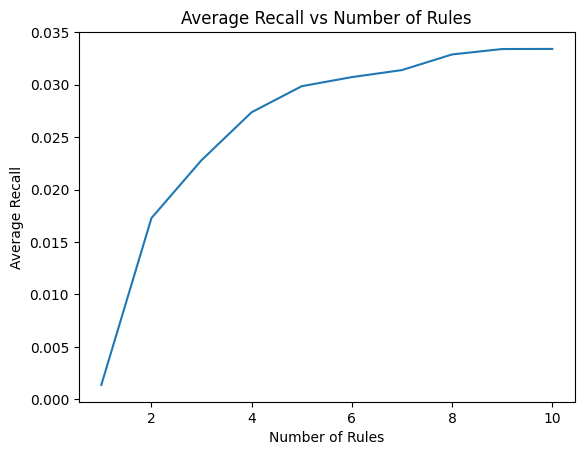

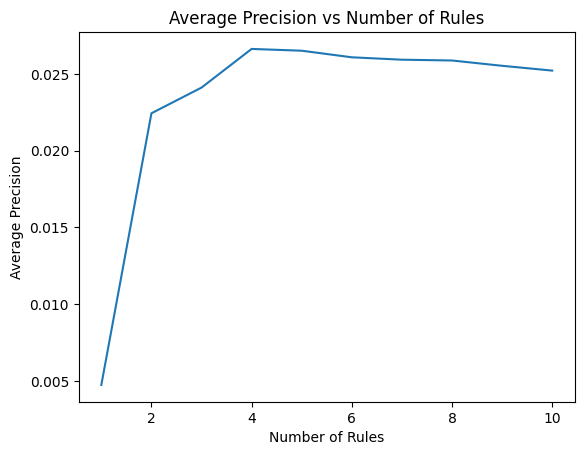

In [21]:
# plot average recall vs number of rules
import matplotlib.pyplot as plt

plt.plot(rule_num, avg_recall_list)
plt.xlabel('Number of Rules')
plt.ylabel('Average Recall')
plt.title('Average Recall vs Number of Rules')
plt.show()

# plot average precision vs number of rules
plt.plot(rule_num, avg_precision_list)
plt.xlabel('Number of Rules')
plt.ylabel('Average Precision')
plt.title('Average Precision vs Number of Rules')
plt.show()
